In [1]:
%matplotlib inline

In [2]:
import requests
import json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
from sklearn import linear_model

from config import nrel_key

In [3]:
#NREL's Transportation Laws and Incentives API

technology = "ELEC"
incentive_type = "TAX"


params = {
    "api_key": nrel_key,
    "technology": technology
    }

base_url = f"https://developer.nrel.gov/api/transportation-incentives-laws/v1.json?"

#print(base_url)

response = requests.get(base_url, params=params).json()

df = pd.DataFrame(response["result"])
df.head()

#print(json.dumps(response,indent=4, sort_keys=True))

,id,state,title,text,enacted_date,amended_date,plaintext,is_recent,seq_num,type,agency,significant_update_date,recent_update_or_new,utility_id,county_ids,technologies,categories,types,references,topics
0,284,US,Congestion Mitigation and Air Quality (CMAQ) I...,<p>The CMAQ Program provides funding to state ...,2005-08-10T00:00:00Z,2021-11-15T00:00:00Z,The CMAQ Program provides funding to state dep...,False,54.0,Incentives,U.S. Department of Transportation,11/29/2021,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[BIOD, ETH, ELEC, HY, IR, NG, PHEV, LPG]","[{'code': 'STATION', 'title': 'Alternative Fue...","[{'id': 8, 'title': 'Incentives', 'code': 'INC'}]","[{'description': 'Public Law 117-58', 'url': '...",[]
1,288,US,Clean Cities Coalition Network,The mission of Clean Cities Coalition Network ...,None,None,The mission of Clean Cities Coalition Network ...,False,21.0,Programs,U.S. Department of Energy,None,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[AFTMKTCONV, BIOD, ETH, ELEC, EFFEC, HEV, HY, ...","[{'code': 'AFTMKTCONV', 'title': 'Aftermarket ...","[{'id': 9, 'title': 'Programs', 'code': 'PROG'}]",[],[]
2,317,US,State Energy Program (SEP) Funding,The SEP provides grants to states to assist in...,None,2021-11-15T00:00:00Z,The SEP provides grants to states to assist in...,False,26.0,Incentives,U.S. Department of Energy,11/29/2021,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[BIOD, ETH, ELEC, EFFEC, HY, NG, PHEV, LPG]","[{'code': 'BIOD', 'title': 'Biodiesel', 'categ...","[{'id': 8, 'title': 'Incentives', 'code': 'INC'}]","[{'description': 'Public Law 117-58', 'url': '...",[]
3,323,US,Clean School Bus,<p>The U.S. Environmental Protection Agency’s ...,None,2021-11-15T00:00:00Z,The U.S. Environmental Protection Agency's (EP...,False,33.0,Incentives,U.S. Environmental Protection Agency,8/16/2022,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[AFTMKTCONV, ETH, ELEC, EFFEC, HY, IR, NG, PHE...","[{'code': 'AFTMKTCONV', 'title': 'Aftermarket ...","[{'id': 8, 'title': 'Incentives', 'code': 'INC'}]","[{'description': 'Public Law 117-58', 'url': '...",[]
4,324,US,Clean Construction and Agriculture,Clean Construction is a voluntary program that...,None,None,Clean Construction is a voluntary program that...,False,34.0,Programs,U.S. Environmental Protection Agency,None,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[BIOD, ELEC, HEV, HY, NG, PHEV, LPG]","[{'code': 'PURCH', 'title': 'Alternative Fuel ...","[{'id': 9, 'title': 'Programs', 'code': 'PROG'}]",[],[]


In [4]:
state_incentives = df.loc[df["type"] == "State Incentives"]

states_sorted = state_incentives.groupby(["state"]).count()['id']


In [5]:
#Importing US Census' 2022 population estimate (for 7/1/2022) (Annual Estimates of the Resident Population for the United States, Regions, States, District of Columbia, and Puerto Rico: April 1, 2020 to July 1, 2022 (NST-EST2022-POP))

ev_registration_path = "resources/ev_registration_by_state.csv"

registration_data = pd.read_csv(ev_registration_path)

state_pop_path = "resources/2022_est_state_pop.csv"

population_data = pd.read_csv(state_pop_path)


In [6]:
population_registration_merge = pd.merge(population_data, registration_data, how = "left", on=["state"])

population_registration_merge.dropna(inplace=True)

population_registration_merge["EVs per 1000"] = (population_registration_merge["Registration Count"] / population_registration_merge["Population (est.)"]) * 1000

population_registration_merge.head()

,Geographic Area,state,Population (est.),State Name,Registration Count,EVs per 1000
0,Alabama,AL,5074296,Alabama,4750.0,0.936090
1,Alaska,AK,733583,Alaska,1290.0,1.758492
2,Arizona,AZ,7359197,Arizona,40740.0,5.535930
3,Arkansas,AR,3045637,Arkansas,2390.0,0.784729
4,California,CA,39029342,California,563070.0,14.426838


In [7]:
incentives_per_1000 = pd.merge(states_sorted, population_registration_merge, how = "left", on=["state"])

incentives_per_1000.rename(columns = {"id":"Number of State Incentives"},inplace=True)

incentives_per_1000

,state,Number of State Incentives,Geographic Area,Population (est.),State Name,Registration Count,EVs per 1000
0,AK,1,Alaska,733583,Alaska,1290.0,1.758492
1,AL,3,Alabama,5074296,Alabama,4750.0,0.936090
2,AR,3,Arkansas,3045637,Arkansas,2390.0,0.784729
3,AZ,6,Arizona,7359197,Arizona,40740.0,5.535930
4,CA,41,California,39029342,California,563070.0,14.426838
5,CO,13,Colorado,5839926,Colorado,37000.0,6.335697
6,CT,7,Connecticut,3626205,Connecticut,13350.0,3.681535
7,DC,4,District of Columbia,671803,District of Columbia,3700.0,5.507567
8,DE,5,Delaware,1018396,Delaware,3010.0,2.955628
9,FL,2,Florida,22244823,Florida,95640.0,4.299427


In [8]:
columns_to_check = ["EVs per 1000","Number of State Incentives"]

for x in columns_to_check:
    expected = incentives_per_1000[x]
    quartiles = expected.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"{x} values below {lower_bound} could be outliers.")
    print(f"{x} values above {upper_bound} could be outliers.")

EVs per 1000 values below -2.610727257988005 could be outliers.
EVs per 1000 values above 8.332033509674387 could be outliers.
Number of State Incentives values below -5.5 could be outliers.
Number of State Incentives values above 14.5 could be outliers.


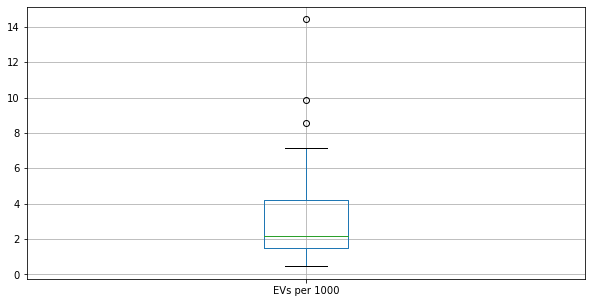

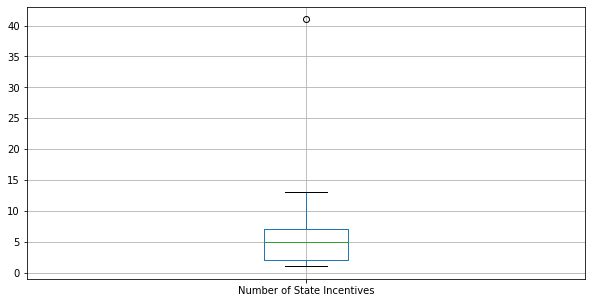

In [9]:
#incentives_per_1000.boxplot("Number of State Incentives",figsize=(10, 5))
for x in columns_to_check:
    incentives_per_1000.boxplot(x,figsize=(10, 5))
    plt.show()

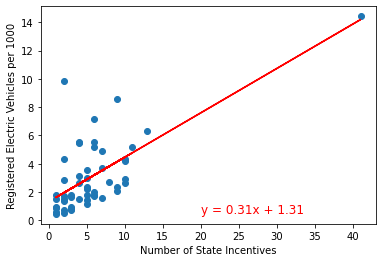

The r-squared is: 0.48592360465636847


In [26]:


y_values = incentives_per_1000['EVs per 1000']
x_values = incentives_per_1000['Number of State Incentives']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.ylabel('Registered Electric Vehicles per 1000')
plt.xlabel('Number of State Incentives')
plt.annotate(line_eq,(20,0.5),fontsize=12,color="red")
plt.show()
print(f"The r-squared is: {rvalue**2}")

In [11]:
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.7


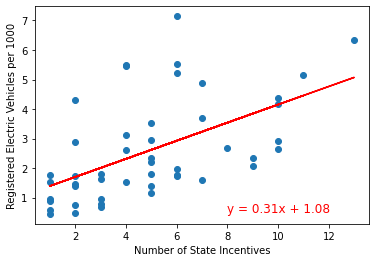

The r-squared is: 0.30334331342642146


In [27]:
outliers_removed_df = incentives_per_1000.loc[((incentives_per_1000["EVs per 1000"] < 8.332033509674387) & (incentives_per_1000["Number of State Incentives"] < 14.5))]

y_values = outliers_removed_df['EVs per 1000']
x_values = outliers_removed_df['Number of State Incentives']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.ylabel('Registered Electric Vehicles per 1000')
plt.xlabel('Number of State Incentives')
plt.annotate(line_eq,(8,0.5),fontsize=12,color="red")
plt.show()
print(f"The r-squared is: {rvalue**2}")

In [14]:
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.55


In [32]:
st.ttest_ind(x_values, y_values, equal_var=False)

Ttest_indResult(statistic=33.54027010554828, pvalue=1.8492133557148254e-37)

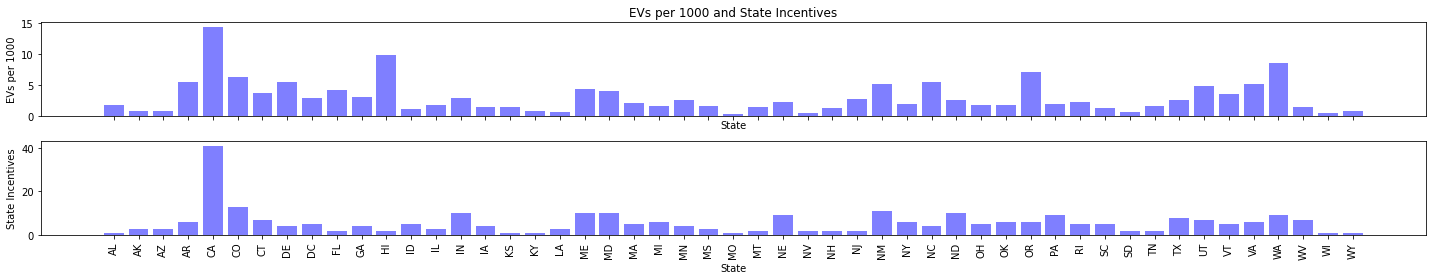

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,4), sharex=True)

x_axis = np.arange(len(incentives_per_1000))
tick_locations = [value for value in x_axis]

ax[0].bar(x_axis, incentives_per_1000["EVs per 1000"], color='b', alpha=0.5, align="center")
ax[0].set_xlabel("State")
ax[0].set_ylabel("EVs per 1000")
ax[0].set_title("EVs per 1000 and State Incentives")
ax[1].bar(x_axis, incentives_per_1000["Number of State Incentives"], color='b', alpha=0.5, align="center")
ax[1].set_xlabel("State")
ax[1].set_ylabel("State Incentives")

plt.xticks(tick_locations, population_registration_merge["state"], rotation="vertical")
plt.tick_params(axis = "both")
plt.tight_layout()
# ax[0].xlim(-0.75, len(x_axis))
# ax[1].xlim(-0.75, len(x_axis))
#plt.ylim(0, max(population_registration_merge["EVs per 1000"])+.001)

plt.show()

In [16]:
y_values = incentives_per_1000['EVs per 1000']
x_values = incentives_per_1000['Number of State Incentives']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

def myfunc(x):
    return slope * x + intercept

expected_values = incentives_per_1000["Number of State Incentives"].apply(myfunc)

incentives_per_1000["Expected EVs per 1000"] = expected_values
incentives_per_1000

,state,Number of State Incentives,Geographic Area,Population (est.),State Name,Registration Count,EVs per 1000,Expected EVs per 1000
0,AK,1,Alaska,733583,Alaska,1290.0,1.758492,1.623776
1,AL,3,Alabama,5074296,Alabama,4750.0,0.936090,2.252100
2,AR,3,Arkansas,3045637,Arkansas,2390.0,0.784729,2.252100
3,AZ,6,Arizona,7359197,Arizona,40740.0,5.535930,3.194585
4,CA,41,California,39029342,California,563070.0,14.426838,14.190248
5,CO,13,Colorado,5839926,Colorado,37000.0,6.335697,5.393718
6,CT,7,Connecticut,3626205,Connecticut,13350.0,3.681535,3.508747
7,DC,4,District of Columbia,671803,District of Columbia,3700.0,5.507567,2.566261
8,DE,5,Delaware,1018396,Delaware,3010.0,2.955628,2.880423
9,FL,2,Florida,22244823,Florida,95640.0,4.299427,1.937938


In [17]:
incentives_per_1000["% of Expected"] = incentives_per_1000["EVs per 1000"] / incentives_per_1000["Expected EVs per 1000"]
incentives_per_1000

,state,Number of State Incentives,Geographic Area,Population (est.),State Name,Registration Count,EVs per 1000,Expected EVs per 1000,% of Expected
0,AK,1,Alaska,733583,Alaska,1290.0,1.758492,1.623776,1.082965
1,AL,3,Alabama,5074296,Alabama,4750.0,0.936090,2.252100,0.415652
2,AR,3,Arkansas,3045637,Arkansas,2390.0,0.784729,2.252100,0.348443
3,AZ,6,Arizona,7359197,Arizona,40740.0,5.535930,3.194585,1.732911
4,CA,41,California,39029342,California,563070.0,14.426838,14.190248,1.016673
5,CO,13,Colorado,5839926,Colorado,37000.0,6.335697,5.393718,1.174644
6,CT,7,Connecticut,3626205,Connecticut,13350.0,3.681535,3.508747,1.049245
7,DC,4,District of Columbia,671803,District of Columbia,3700.0,5.507567,2.566261,2.146144
8,DE,5,Delaware,1018396,Delaware,3010.0,2.955628,2.880423,1.026109
9,FL,2,Florida,22244823,Florida,95640.0,4.299427,1.937938,2.218558


In [18]:
incentives_per_1000.sort_values(by="% of Expected", ascending=False).head()



,state,Number of State Incentives,Geographic Area,Population (est.),State Name,Registration Count,EVs per 1000,Expected EVs per 1000,% of Expected
11,HI,2,Hawaii,1440196,Hawaii,14220.0,9.873656,1.937938,5.094929
37,OR,6,Oregon,4240137,Oregon,30290.0,7.143637,3.194585,2.236171
9,FL,2,Florida,22244823,Florida,95640.0,4.299427,1.937938,2.218558
7,DC,4,District of Columbia,671803,District of Columbia,3700.0,5.507567,2.566261,2.146144
33,NV,4,Nevada,3177772,Nevada,17380.0,5.469241,2.566261,2.131209


In [19]:
incentives_per_1000.sort_values(by="% of Expected", ascending=True).head()

,state,Number of State Incentives,Geographic Area,Population (est.),State Name,Registration Count,EVs per 1000,Expected EVs per 1000,% of Expected
28,ND,2,North Dakota,779261,North Dakota,380.0,0.487641,1.937938,0.251629
25,MS,1,Mississippi,2940057,Mississippi,1310.0,0.445570,1.623776,0.274403
18,LA,3,Louisiana,4590241,Louisiana,3180.0,0.692774,2.252100,0.307613
2,AR,3,Arkansas,3045637,Arkansas,2390.0,0.784729,2.252100,0.348443
49,WV,1,West Virginia,1775156,West Virginia,1010.0,0.568964,1.623776,0.350396


In [20]:
#Importing state urban population data from https://www.icip.iastate.edu/tables/population/urban-pct-states

urban_pct_path = "resources/state_urban_percentage.csv"

urban_pct_data = pd.read_csv(urban_pct_path)

urban_pct_df = pd.merge(incentives_per_1000, urban_pct_data, how = "left", on=["state"])

urban_pct_df.head()

,state,Number of State Incentives,Geographic Area,Population (est.),State Name,Registration Count,EVs per 1000,Expected EVs per 1000,% of Expected,Area Name,Urban %
0,AK,1,Alaska,733583,Alaska,1290.0,1.758492,1.623776,1.082965,Alaska,66.0
1,AL,3,Alabama,5074296,Alabama,4750.0,0.936090,2.252100,0.415652,Alabama,59.0
2,AR,3,Arkansas,3045637,Arkansas,2390.0,0.784729,2.252100,0.348443,Arkansas,56.2
3,AZ,6,Arizona,7359197,Arizona,40740.0,5.535930,3.194585,1.732911,Arizona,89.8
4,CA,41,California,39029342,California,563070.0,14.426838,14.190248,1.016673,California,95.0


In [21]:
urban_pct_df.sort_values(by="% of Expected", ascending=False).head()

,state,Number of State Incentives,Geographic Area,Population (est.),State Name,Registration Count,EVs per 1000,Expected EVs per 1000,% of Expected,Area Name,Urban %
11,HI,2,Hawaii,1440196,Hawaii,14220.0,9.873656,1.937938,5.094929,Hawaii,91.9
37,OR,6,Oregon,4240137,Oregon,30290.0,7.143637,3.194585,2.236171,Oregon,81.0
9,FL,2,Florida,22244823,Florida,95640.0,4.299427,1.937938,2.218558,Florida,91.2
7,DC,4,District of Columbia,671803,District of Columbia,3700.0,5.507567,2.566261,2.146144,District of Columbia,100.0
33,NV,4,Nevada,3177772,Nevada,17380.0,5.469241,2.566261,2.131209,Nevada,94.2


In [22]:
urban_pct_df.sort_values(by="% of Expected", ascending=True).head()

,state,Number of State Incentives,Geographic Area,Population (est.),State Name,Registration Count,EVs per 1000,Expected EVs per 1000,% of Expected,Area Name,Urban %
28,ND,2,North Dakota,779261,North Dakota,380.0,0.487641,1.937938,0.251629,North Dakota,59.9
25,MS,1,Mississippi,2940057,Mississippi,1310.0,0.445570,1.623776,0.274403,Mississippi,49.4
18,LA,3,Louisiana,4590241,Louisiana,3180.0,0.692774,2.252100,0.307613,Louisiana,73.2
2,AR,3,Arkansas,3045637,Arkansas,2390.0,0.784729,2.252100,0.348443,Arkansas,56.2
49,WV,1,West Virginia,1775156,West Virginia,1010.0,0.568964,1.623776,0.350396,West Virginia,48.7


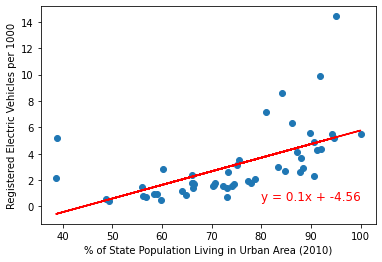

The r-squared is: 0.3341050693021061


In [28]:
y_values = urban_pct_df['EVs per 1000']
x_values = urban_pct_df['Urban %']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.ylabel('Registered Electric Vehicles per 1000')
plt.xlabel('% of State Population Living in Urban Area (2010)')
plt.annotate(line_eq,(80,0.5),fontsize=12,color="red")
plt.show()
print(f"The r-squared is: {rvalue**2}")

In [29]:
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.58


In [31]:
st.ttest_ind(x_values, y_values, equal_var=False)

Ttest_indResult(statistic=33.54027010554828, pvalue=1.8492133557148254e-37)